In [22]:
# LinkedIn Jobs & Skills (2024) — Cleaning and EDA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

jobs = pd.read_csv("linkedin_job_postings.csv", low_memory=False)
skills = pd.read_csv("job_skills.csv", low_memory=False)
summ = pd.read_csv("job_summary.csv", low_memory=False)

In [24]:
print("jobs columns:", list(jobs.columns))
print("skills columns:", list(skills.columns))
print("summary columns:", list(summ.columns))

jobs columns: ['job_link', 'last_processed_time', 'got_summary', 'got_ner', 'is_being_worked', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'search_position', 'job_level', 'job_type']
skills columns: ['job_link', 'job_skills']
summary columns: ['job_link', 'job_summary']


In [25]:
bool_map = {"true":1,"t":1,"yes":1,"y":1,"1":1,"false":0,"f":0,"no":0,"n":0,"0":0}
for c in ["got_summary","got_ner","is_being_worked"]:
    s = jobs[c].astype(str).str.strip().str.lower()
    v = s.map(bool_map)
    nums = pd.to_numeric(s, errors="coerce")
    jobs[c] = v.fillna(nums).fillna(0).astype("int64")

In [26]:
rows_before = len(jobs)
jobs_cols_before = jobs.dtypes.astype(str).rename("before").to_frame()

jobs.columns = jobs.columns.str.strip()
skills.columns = skills.columns.str.strip()
summ.columns = summ.columns.str.strip()

jobs["job_link"] = jobs["job_link"].astype(str).str.strip()
jobs["job_title"] = jobs["job_title"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
jobs["company"] = jobs["company"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
jobs["job_location"] = jobs["job_location"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
jobs["job_level"] = jobs["job_level"].astype(str).str.strip()
jobs["job_type"] = jobs["job_type"].astype(str).str.strip()
jobs["got_summary"] = jobs["got_summary"].astype(int)
jobs["got_ner"] = jobs["got_ner"].astype(int)
jobs["is_being_worked"] = jobs["is_being_worked"].astype(int)

skills["job_link"] = skills["job_link"].astype(str).str.strip()
skills["job_skills"] = skills["job_skills"].astype(str).str.lower().str.replace(r"[;\|]", ",", regex=True).str.replace(r"\s*,\s*", ",", regex=True).str.replace(r"\s+", " ", regex=True).str.strip(", ").str.strip()

dup_count = jobs.duplicated(subset=["job_link"]).sum()
jobs = jobs.drop_duplicates(subset=["job_link"])

jobs_sk = jobs.merge(skills, on="job_link", how="left")
jobs_sk["job_skills"] = jobs_sk["job_skills"]
jobs_sk["skills_list"] = jobs_sk["job_skills"].fillna("").str.split(",").apply(lambda xs: [x.strip() for x in xs if x.strip()!=""])
jobs_sk["skill_count"] = jobs_sk["skills_list"].apply(len)

all_skills_series = jobs_sk["skills_list"].explode()
unique_skills = pd.Series(all_skills_series.unique())
unique_skills = unique_skills[unique_skills.notna() & (unique_skills.str.len()>0)]
skills_unique_count = unique_skills.nunique(dropna=True)

jobs_cols_after = jobs_sk.dtypes.astype(str).rename("after").to_frame()
dtype_changes = jobs_cols_before.join(jobs_cols_after, how="outer")

rows_after = len(jobs_sk)
out_path = Path("linkedin_jobs_cleaned.csv")
jobs_sk.to_csv(out_path, index=False)
final_file_size_mb = out_path.stat().st_size / (1024*1024)

pct_missing_job_link = jobs_sk["job_link"].isna().mean() * 100
uniq_tbl = (jobs_sk.assign(skills_list=jobs_sk["skills_list"].apply(tuple)).nunique(dropna=False).sort_values(ascending=False).to_frame("unique_vals"))
display(uniq_tbl)
pct_missing_job_link = jobs_sk["job_link"].isna().mean() * 100
pct_missing_job_skills = jobs_sk["job_skills"].isna().mean() * 100

,unique_vals
job_link,1348454
skills_list,1286039
job_skills,1286039
last_processed_time,722748
job_title,583969
company,90605
job_location,29154
search_position,1993
search_city,1018
skill_count,241


In [27]:
print(pct_missing_job_link, pct_missing_job_skills)

0.0 3.861681599817272


In [28]:
print("Total number of rows after cleaning:", rows_after)
print("Total number of columns after cleaning:", jobs_sk.shape[1])
print("Number of unique skills identified:", int(skills_unique_count))
print("Percentage of missing values in job_link column:", round(pct_missing_job_link, 4))
print("Percentage of missing values in job_skills column:", round(pct_missing_job_skills, 4))
print("Final file size (MB):", round(final_file_size_mb, 4))

Total number of rows after cleaning: 1348454
Total number of columns after cleaning: 17
Number of unique skills identified: 2772601
Percentage of missing values in job_link column: 0.0
Percentage of missing values in job_skills column: 3.8617
Final file size (MB): 1427.5115


In [29]:
## Section 3A — Data Cleaning Process
##1) Missing values were retained for transparent reporting; `job_skills` was normalized and split to derive `skills_list` and `skill_count`.  
##2) Duplicate job postings were identified and removed using `job_link`.  
##3) Data type conversions: boolean-like flags (`got_summary`, `got_ner`, `is_being_worked`) were cast to integers; text columns trimmed and whitespace-collapsed.  
##4) Skill strings were lowercased, delimiters unified to commas, trimmed, and parsed into `skills_list`; `skill_count` equals the list length.  
##5) Special characters and repeated whitespace in text fields were normalized.  
##6) Final dataset exported to `linkedin_jobs_cleaned.csv`; statistics include rows before vs. after cleaning and file size.

In [30]:
print("Rows before cleaning:", rows_before)
print("Rows after cleaning:", rows_after)
print("Duplicates found and removed:", dup_count)
print("Data type changes (before → after):")
display(dtype_changes)
mv_counts = jobs_sk.isna().sum().to_frame("missing_count")
mv_counts["missing_pct"] = (mv_counts["missing_count"]/len(jobs_sk))*100
display(mv_counts.sort_values("missing_count", ascending=False))

Rows before cleaning: 1348454
Rows after cleaning: 1348454
Duplicates found and removed: 0
Data type changes (before → after):


,before,after
company,object,object
first_seen,object,object
got_ner,int64,int64
got_summary,int64,int64
is_being_worked,int64,int64
job_level,object,object
job_link,object,object
job_location,object,object
job_skills,NaN,object
job_title,object,object


,missing_count,missing_pct
job_skills,52073,3.8617
job_link,0,0.0000
search_city,0,0.0000
skills_list,0,0.0000
job_type,0,0.0000
job_level,0,0.0000
search_position,0,0.0000
search_country,0,0.0000
first_seen,0,0.0000
last_processed_time,0,0.0000


In [31]:
print("EDA Step 1 — df.info()")
jobs_sk.info()

EDA Step 1 — df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348454 entries, 0 to 1348453
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   job_link             1348454 non-null  object
 1   last_processed_time  1348454 non-null  object
 2   got_summary          1348454 non-null  int64 
 3   got_ner              1348454 non-null  int64 
 4   is_being_worked      1348454 non-null  int64 
 5   job_title            1348454 non-null  object
 6   company              1348454 non-null  object
 7   job_location         1348454 non-null  object
 8   first_seen           1348454 non-null  object
 9   search_city          1348454 non-null  object
 10  search_country       1348454 non-null  object
 11  search_position      1348454 non-null  object
 12  job_level            1348454 non-null  object
 13  job_type             1348454 non-null  object
 14  job_skills           1296381 non-null  obje

In [32]:
print("EDA Step 2 — Numeric Summary")
display(jobs_sk.describe().T)

EDA Step 2 — Numeric Summary


,count,mean,std,min,25%,50%,75%,max
got_summary,"1,348,454.0000",0.9625,0.1900,0.0000,1.0000,1.0000,1.0000,1.0000
got_ner,"1,348,454.0000",0.9614,0.1926,0.0000,1.0000,1.0000,1.0000,1.0000
is_being_worked,"1,348,454.0000",0.0011,0.0331,0.0000,0.0000,0.0000,0.0000,1.0000
skill_count,"1,348,454.0000",19.9708,12.1058,0.0000,13.0000,18.0000,25.0000,463.0000


EDA Step 3 — Missing Value Analysis


,missing_count,missing_pct
job_skills,52073,3.8617
job_link,0,0.0000
search_city,0,0.0000
skills_list,0,0.0000
job_type,0,0.0000
job_level,0,0.0000
search_position,0,0.0000
search_country,0,0.0000
first_seen,0,0.0000
last_processed_time,0,0.0000


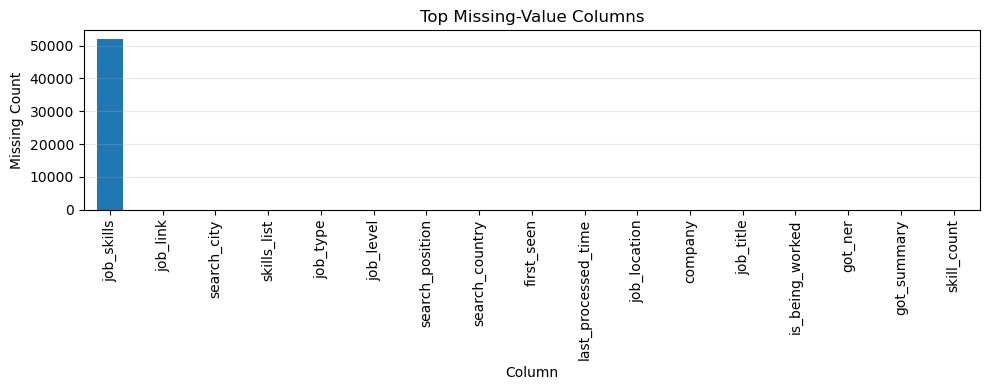

In [33]:
print("EDA Step 3 — Missing Value Analysis")
mv = jobs_sk.isna().sum().to_frame("missing_count")
mv["missing_pct"] = (mv["missing_count"]/len(jobs_sk))*100
display(mv.sort_values("missing_count", ascending=False))
plt.figure(figsize=(10,4))
mv["missing_count"].sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Top Missing-Value Columns")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 4 — Skill Count Distribution
Mean skill_count: 19.97
Median skill_count: 18.0


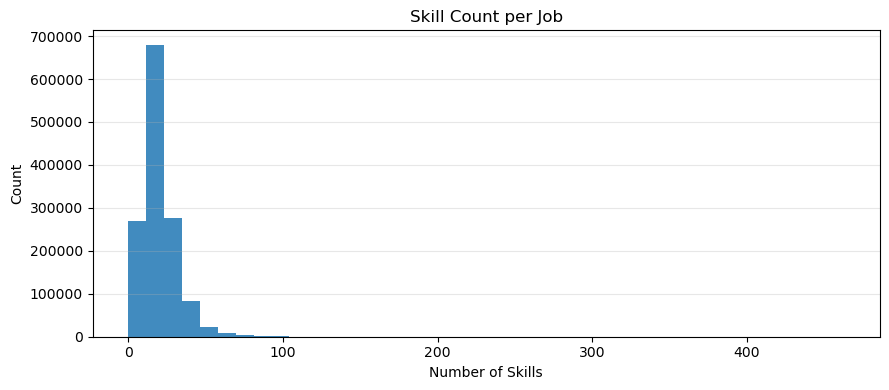

In [34]:
print("EDA Step 4 — Skill Count Distribution")
mean_sc = jobs_sk["skill_count"].mean()
median_sc = jobs_sk["skill_count"].median()
print("Mean skill_count:", round(mean_sc,2))
print("Median skill_count:", round(median_sc,2))
plt.figure(figsize=(9,4))
jobs_sk["skill_count"].plot(kind="hist", bins=40, alpha=0.85)
plt.title("Skill Count per Job")
plt.xlabel("Number of Skills")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 5 — Top 50 Skills


,count
skills_list,
communication,370143
customer service,278104
teamwork,227610
communication skills,195954
leadership,185187
problem solving,149037
time management,142912
attention to detail,133978
problemsolving,129330


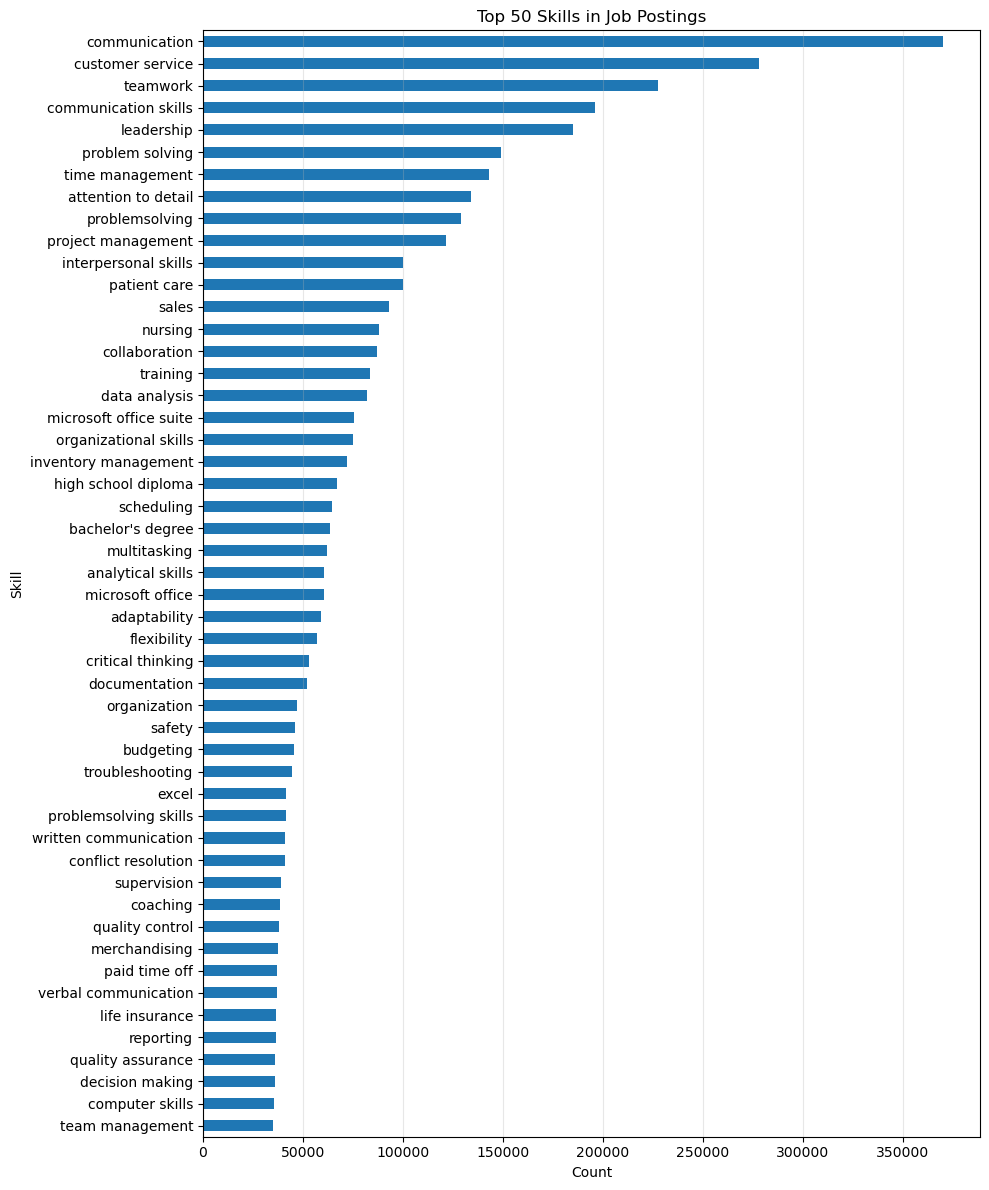

In [35]:
print("EDA Step 5 — Top 50 Skills")
top_n = 50
top_sk = jobs_sk["skills_list"].explode().value_counts().head(top_n)
display(top_sk.to_frame("count"))
plt.figure(figsize=(10,12))
top_sk.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 50 Skills in Job Postings")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 6 — Skill Popularity by Job Level


,job_level,skills_list,count
104466,Associate,communication,39543
129942,Associate,customer service,30913
437136,Associate,teamwork,28434
104837,Associate,communication skills,21436
445151,Associate,time management,18200
53551,Associate,attention to detail,17255
350314,Associate,problem solving,15881
350405,Associate,problemsolving,14135
391887,Associate,sales,13467
257967,Associate,leadership,13141


<Figure size 1000x600 with 0 Axes>

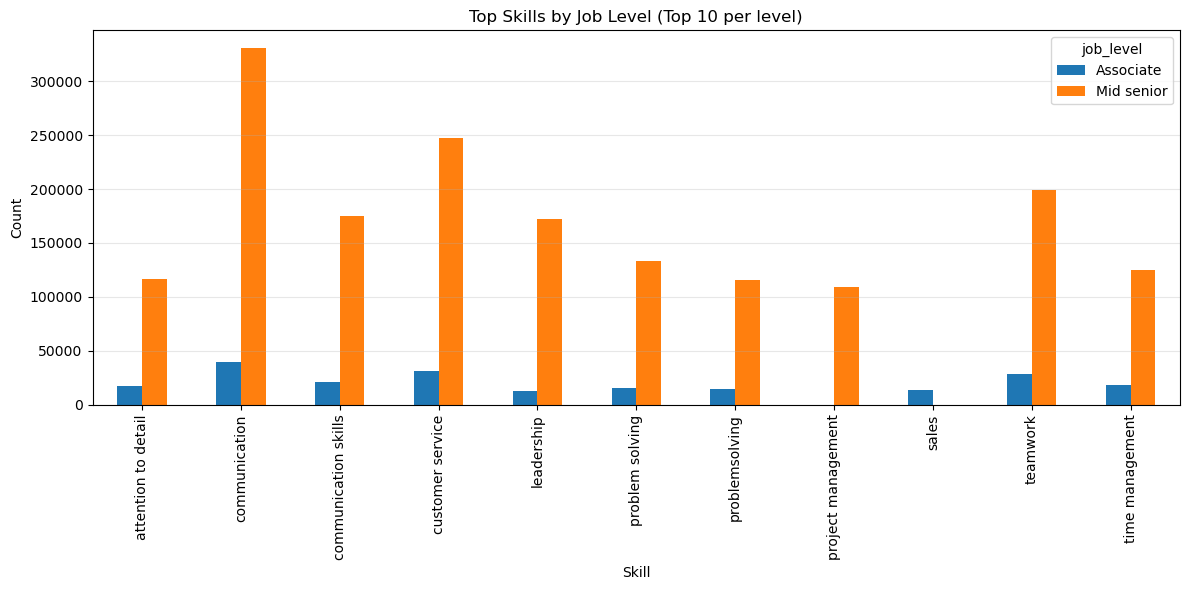

In [36]:
print("EDA Step 6 — Skill Popularity by Job Level")
level_sk = jobs_sk.explode("skills_list").groupby(["job_level","skills_list"]).size().rename("count").reset_index()
top_level_sk = level_sk.sort_values(["job_level","count"], ascending=[True,False]).groupby("job_level").head(10)
display(top_level_sk.head(30))
pivot_level = top_level_sk.pivot(index="skills_list", columns="job_level", values="count").fillna(0).head(20)
plt.figure(figsize=(10,6))
pivot_level.plot(kind="bar", figsize=(12,6))
plt.title("Top Skills by Job Level (Top 10 per level)")
plt.xlabel("Skill")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 7 — Skill Popularity by Job Type


,job_type,skills_list,count
26724,Hybrid,sales,2772
6895,Hybrid,communication,2473
1471,Hybrid,account management,2224
30832,Hybrid,time management,1593
6945,Hybrid,communication skills,1426
4515,Hybrid,business development,1417
9104,Hybrid,customer service,1369
19754,Hybrid,microsoft office suite,1241
20618,Hybrid,negotiation,1236
23829,Hybrid,problem solving,1233


<Figure size 1000x600 with 0 Axes>

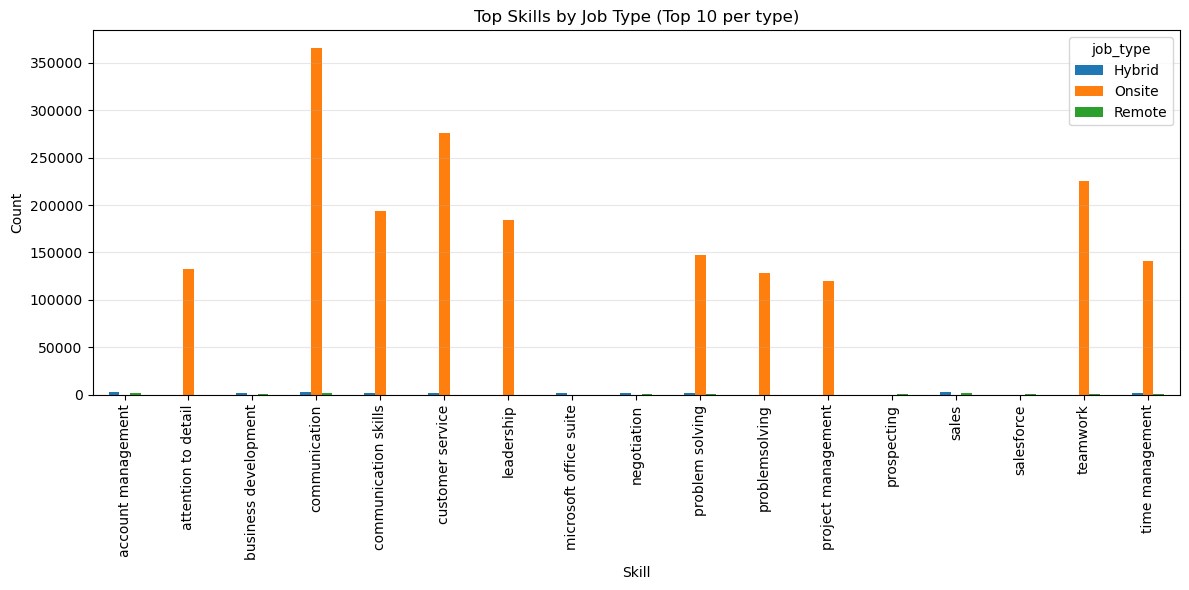

In [37]:
print("EDA Step 7 — Skill Popularity by Job Type")
type_sk = jobs_sk.explode("skills_list").groupby(["job_type","skills_list"]).size().rename("count").reset_index()
top_type_sk = type_sk.sort_values(["job_type","count"], ascending=[True,False]).groupby("job_type").head(10)
display(top_type_sk.head(30))
pivot_type = top_type_sk.pivot(index="skills_list", columns="job_type", values="count").fillna(0).head(20)
plt.figure(figsize=(10,6))
pivot_type.plot(kind="bar", figsize=(12,6))
plt.title("Top Skills by Job Type (Top 10 per type)")
plt.xlabel("Skill")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 8 — Title Length vs Skill Count
Correlation (title_word_count, skill_count): -0.007


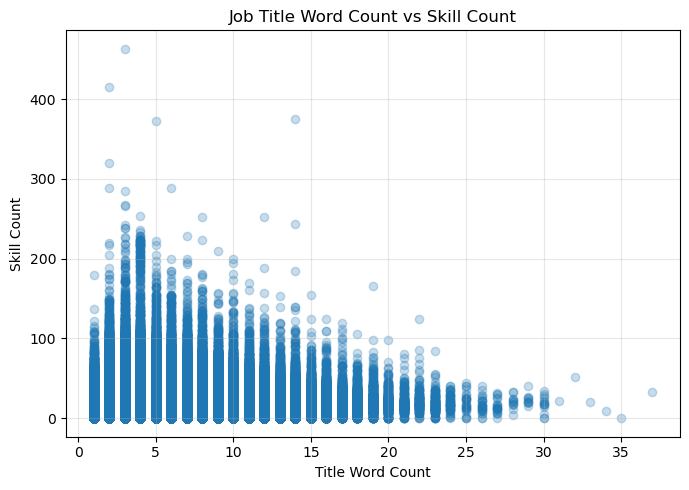

In [38]:
print("EDA Step 8 — Title Length vs Skill Count")
title_len = jobs_sk["job_title"].astype(str).str.split().apply(len)
corr_tlen_sc = pd.concat([title_len, jobs_sk["skill_count"]], axis=1).corr().iloc[0,1]
print("Correlation (title_word_count, skill_count):", round(corr_tlen_sc,4))
plt.figure(figsize=(7,5))
plt.scatter(title_len, jobs_sk["skill_count"], alpha=0.25)
plt.title("Job Title Word Count vs Skill Count")
plt.xlabel("Title Word Count")
plt.ylabel("Skill Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 9 — Top Companies and Locations


,count
company,
Health eCareers,41598
Jobs for Humanity,27680
TravelNurseSource,16142
Dollar General,14815
PracticeLink,9738
Energy Jobline,9365
Gotham Enterprises Ltd,8935
Jobot,8713
ClearanceJobs,8599


,count
job_location,
"New York, NY",13436
"London, England, United Kingdom",11761
"Houston, TX",10999
"Chicago, IL",10790
"Los Angeles, CA",10262
"Atlanta, GA",9208
"Boston, MA",8403
"Dallas, TX",8005
"Austin, TX",7678


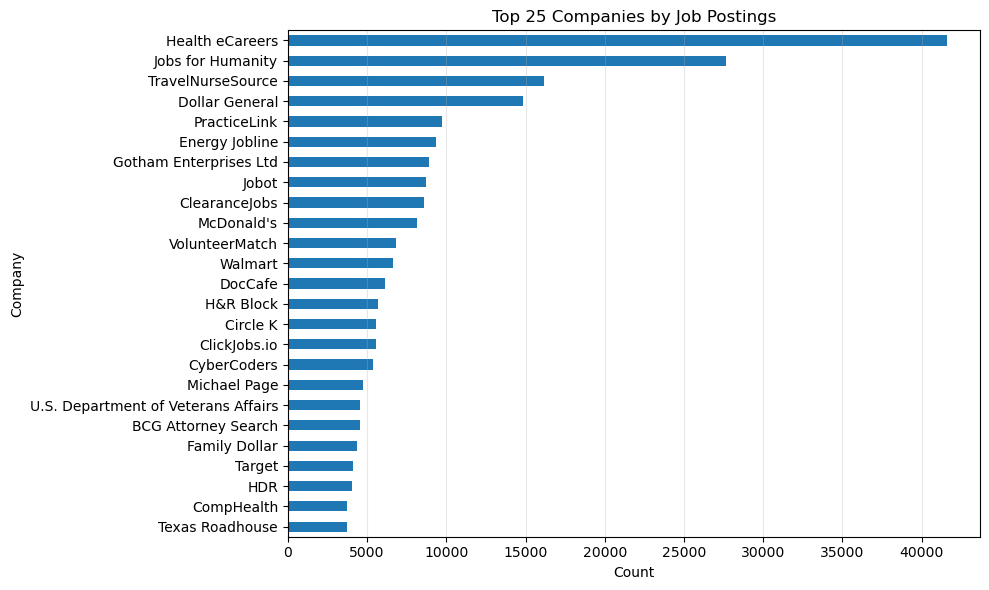

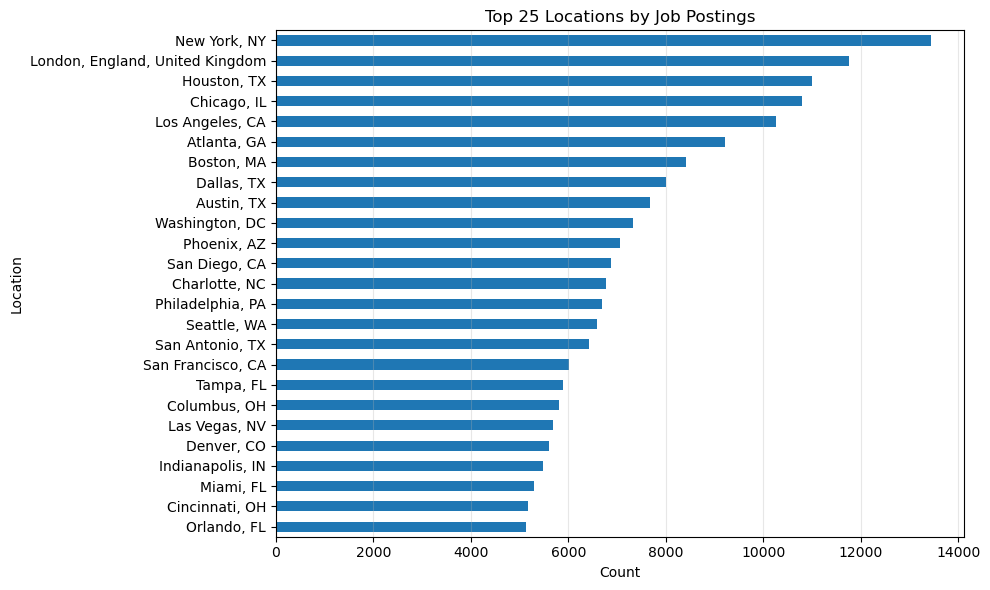

In [39]:
print("EDA Step 9 — Top Companies and Locations")
top_companies = jobs_sk["company"].value_counts().head(25)
top_locs = jobs_sk["job_location"].value_counts().head(25)
display(top_companies.to_frame("count"), top_locs.to_frame("count"))
plt.figure(figsize=(10,6))
top_companies.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 25 Companies by Job Postings")
plt.xlabel("Count")
plt.ylabel("Company")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
top_locs.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 25 Locations by Job Postings")
plt.xlabel("Count")
plt.ylabel("Location")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

EDA Step 10 — Correlation Heatmap


,got_summary,got_ner,is_being_worked,skill_count
got_summary,1.0000,0.9852,0.0065,0.3257
got_ner,0.9852,1.0000,-0.1652,0.3306
is_being_worked,0.0065,-0.1652,1.0000,-0.0546
skill_count,0.3257,0.3306,-0.0546,1.0000


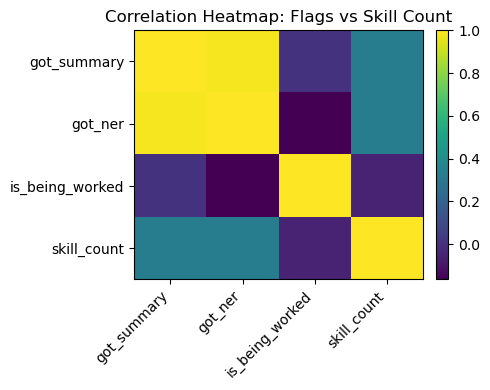

In [40]:
print("EDA Step 10 — Correlation Heatmap")
flags = jobs_sk[["got_summary","got_ner","is_being_worked","skill_count"]].astype(float)
corr = flags.corr()
display(corr)
plt.figure(figsize=(5,4))
im = plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(flags.columns)), flags.columns, rotation=45, ha="right")
plt.yticks(range(len(flags.columns)), flags.columns)
plt.title("Correlation Heatmap: Flags vs Skill Count")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [41]:
jobs_sk[["job_link","job_title","company","job_location","job_level","job_type","job_skills","skill_count","got_summary","got_ner","is_being_worked"]].to_csv("linkedin_jobs_skills_clean.csv", index=False)
print("Saved:", Path("linkedin_jobs_skills_clean.csv").resolve())

Saved: /Users/prithvicharanbalajibabu/linkedin_jobs_skills_clean.csv
